# EECS 442 Final Project

In [1]:
# Import libraries.
import os
import glob
import imageio
import random, shutil
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import librosa
import librosa.display
import functions as fun

The GTZAN dataset for music genre classification is dowloaded from [Kaggle](https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification).

## Inspect the data

This section demonstrates how to transform a sound wave to a spectrogram and compare it with the spectrogram that was included with the downloaded dataset.

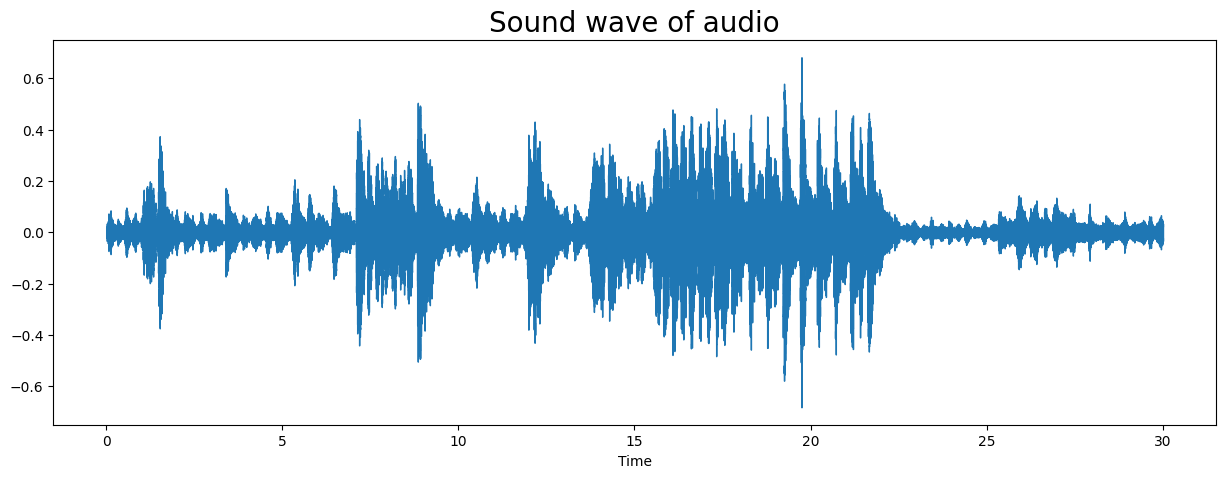

In [2]:
# Inspect an audio file from the dataset.
sample_path = 'Data/genres_original/jazz/jazz.00000.wav'
y, sample_rate = librosa.load(sample_path)

plt.figure(figsize=(15, 5))
librosa.display.waveshow(y=y, sr=sample_rate)
plt.title("Sound wave of audio", fontsize=20)
plt.show()

Shape of D object: (1025, 1293)


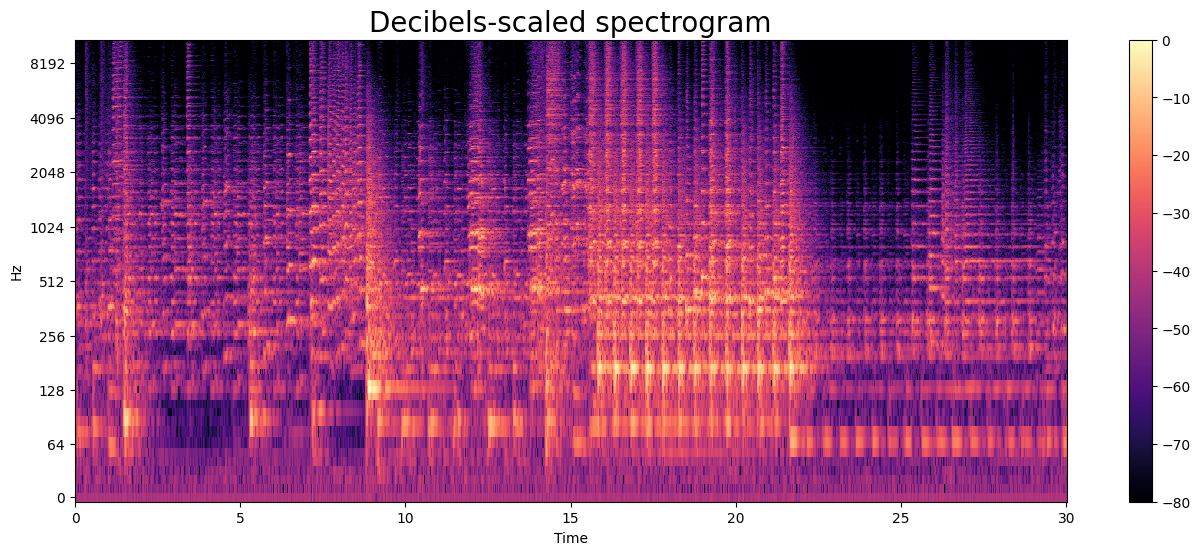

In [3]:
# Convert sound wave to spectrogram.

# Short-time Fourier transform (STFT).

D = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
print('Shape of D object:', np.shape(D))

# Convert amplitude spectrogram to Decibels-scaled spectrogram.

DB = librosa.amplitude_to_db(D, ref = np.max)

# Creating the spectogram.

plt.figure(figsize = (16, 6))
librosa.display.specshow(DB, sr=sample_rate, hop_length=512,
                         x_axis='time', y_axis='log')
plt.colorbar()
plt.title('Decibels-scaled spectrogram', fontsize=20)
plt.show()

The mel spectrogram uses mel sclae intead of a linear one: [mel scale](https://en.wikipedia.org/wiki/Mel_scale) is a perceptual scale of pitches judged by listeners to be equal in distance from one another. The reference point between this scale and normal frequency measurement is defined by assigning a perceptual pitch of 1000 mels to a 1000 Hz tone, 40 dB above the listener's threshold. Above about 500 Hz, increasingly large intervals are judged by listeners to produce equal pitch increments.

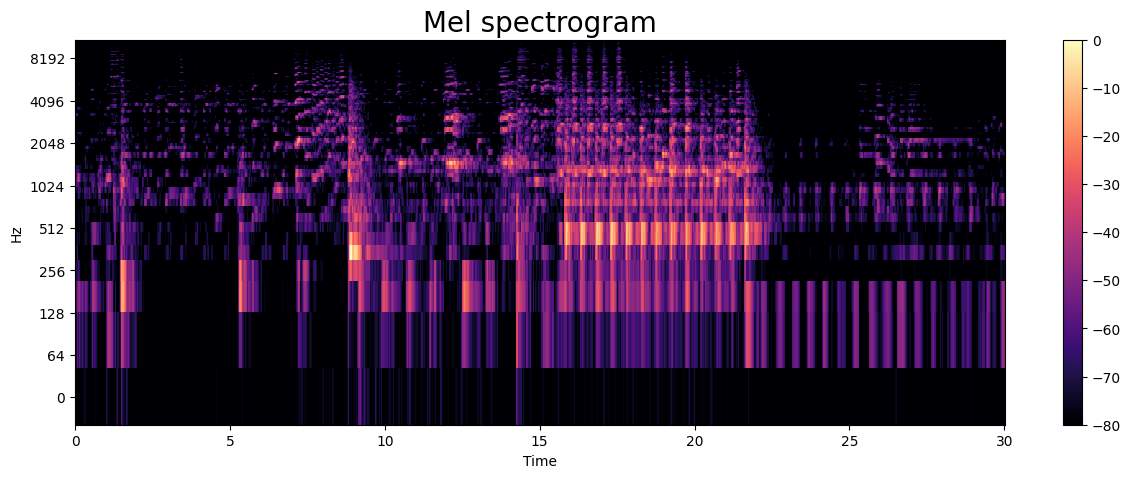

In [4]:
#Generate Dataset, ALL PREVIOUS WILL BE ERASED

# base_dir = 'Data/genres_original/'

# genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# for genre in genres:
#     genre_path = base_dir + genre + '/'
#     new_genre_path = 'Data/images_linear/' + genre
#     if os.path.exists(new_genre_path):
#       shutil.rmtree(new_genre_path)
#     os.makedirs(new_genre_path)
    
#     for filename in os.listdir(genre_path):
#         file_path = genre_path + filename
#         print(file_path)

#         y, sample_rate = librosa.load(file_path)
#         D = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
#         DB = librosa.amplitude_to_db(D, ref = np.max)
        
#         output_size = (432, 288)
#         dpi = 100
#         fig_size = (output_size[0] / dpi, output_size[1] / dpi)
#         plt.figure(figsize=fig_size, dpi=dpi)
              
#         librosa.display.specshow(DB, sr=sample_rate, hop_length=512,
#                          x_axis='time', y_axis='log')
#         plt.axis('off')
#         # Adjusting whitespace
#         # plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
        
        
#         new_filename = '.'.join(filename.split('.')[:-1]) + '.png'
#         plt.savefig('Data/images_linear/' + genre + '/' + new_filename)
#         plt.close()
        
#         ##resize image, values need tweaking ##################################################################
#         ##for densenet want image sizes of multiples of 32, 224x224
#         # transform = transforms.Compose([
#         # transforms.Resize(256),
#         # transforms.CenterCrop(224),
#         # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#         # ])

y, sr = librosa.load(sample_path)

S = librosa.feature.melspectrogram(y=y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)


plt.figure(figsize=(15, 5))
librosa.display.specshow(S_DB, sr=sr, hop_length=512,
                         x_axis='time', y_axis='log')
plt.colorbar()
plt.title("Mel spectrogram", fontsize=20)
plt.show()



(288, 432, 4)


C:\Users\Sunny Wang\AppData\Local\Temp\ipykernel_22156\1207031028.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)


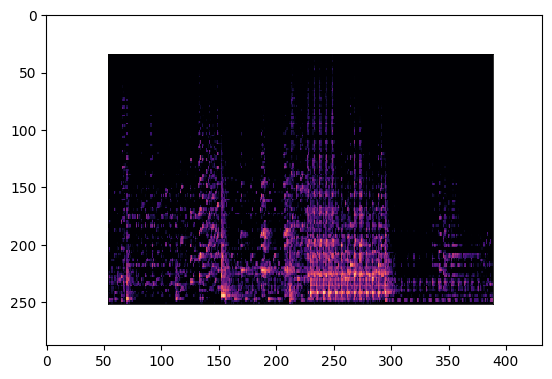

In [5]:
# Visualize the mel spectrogram of the same sample from the dataset.

img_path = 'Data/images_original/jazz/jazz00000.png'
img = imageio.imread(img_path)
print(img.shape)

plt.imshow(img, interpolation='nearest')
plt.show()

## Train a simple CNN

In [6]:
# @title Helper functions (run me)

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
      print("WARNING: For this notebook to perform best, "
          "if possible, in the menu under `Runtime` -> "
          "`Change runtime type.`  select `GPU` ")
  else:
      print("GPU is enabled in this notebook.")

  return device

In [7]:
device = set_device()

GPU is enabled in this notebook.


In [8]:
# Create folder with training, testing and validation data.

mel_spectrograms_dir = "Data/images_original/"
linear_spectrograms_dir = "Data/images_linear/"
folder_names = ['Data/train/', 'Data/test/', 'Data/val/']
train_dir = folder_names[0]
test_dir = folder_names[1]
val_dir = folder_names[2]

for f in folder_names:
  if os.path.exists(f):
    shutil.rmtree(f)
    os.mkdir(f)
  else:
    os.mkdir(f)

# Loop over all genres.

genres = list(os.listdir(mel_spectrograms_dir))
for g in genres:
  # find all images & split in train, test, and validation
  src_file_paths= []
  for im in glob.glob(os.path.join(mel_spectrograms_dir, f'{g}',"*.png"), recursive=True):
    src_file_paths.append(im)
  for im in glob.glob(os.path.join(linear_spectrograms_dir, f'{g}',"*.png"), recursive=True):
    src_file_paths.append(im)
  random.shuffle(src_file_paths)
  test_files = src_file_paths[0:20]
  val_files = src_file_paths[20:40]
  train_files = src_file_paths[40:]

  #  make destination folders for train and test images
  for f in folder_names:
    if not os.path.exists(os.path.join(f + f"{g}")):
      os.mkdir(os.path.join(f + f"{g}"))

  # copy training and testing images over
  for f in train_files:
    shutil.copy(f, os.path.join(os.path.join(train_dir + f"{g}") + '/',os.path.split(f)[1]))
  for f in test_files:
    shutil.copy(f, os.path.join(os.path.join(test_dir + f"{g}") + '/',os.path.split(f)[1]))
  for f in val_files:
    shutil.copy(f, os.path.join(os.path.join(val_dir + f"{g}") + '/',os.path.split(f)[1]))

In [9]:
# Data loading.

train_dataset = datasets.ImageFolder(
    train_dir,
    transforms.Compose([
        transforms.ToTensor(),
    ]))

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=25, shuffle=True, num_workers=0)

for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)

val_dataset = datasets.ImageFolder(
    val_dir,
    transforms.Compose([
        transforms.ToTensor(),
    ]))

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=25, shuffle=True, num_workers=0)

for inputs, labels in val_loader:
    inputs, labels = inputs.to(device), labels.to(device)

test_dataset = datasets.ImageFolder(
    test_dir,
    transforms.Compose([
        transforms.ToTensor(),
    ]))

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=25, shuffle=True, num_workers=0)
 
for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)

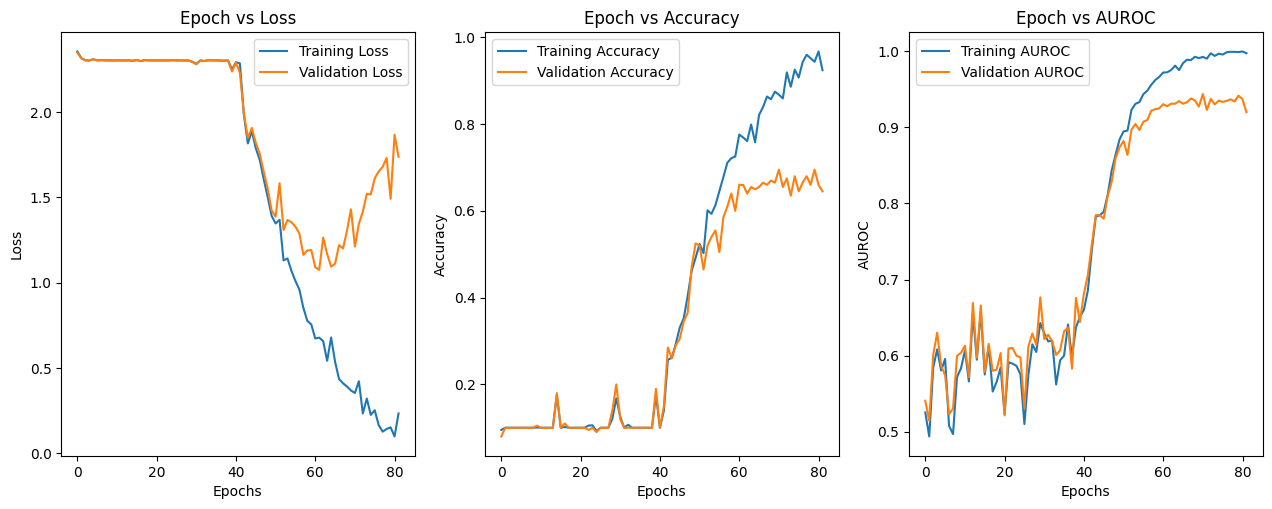

Finished Training


In [10]:
# Run training.
fun.set_seed(442)
net = fun.music_net().to(device)
best = fun.train(net, device, train_loader, val_loader, test_loader) 

In [11]:
#Run model on test set at best epoch

criterion = nn.CrossEntropyLoss()

# Attempts to restore the latest checkpoint if exists
print("Loading cnn...")
model, start_epoch, stats = fun.restore_checkpoint(net, './checkpoints/')

# Evaluate the model
fun.evaluate_epoch(
    train_loader,
    val_loader,
    test_loader,
    model,
    criterion,
    start_epoch,
    stats,
    include_test=True,
)

Loading cnn...
Which epoch to load from? Choose in range [0, 81]. Enter 0 to train from scratch.
>> Loading from checkpoint ./checkpoints/epoch=61.checkpoint.pth.tar?
=> Successfully restored checkpoint (trained for 61 epochs)
Epoch 61
	Validation Accuracy:0.66
	Validation Loss:1.0756
	Validation AUROC:0.9278
	Train Accuracy:0.7691
	Train Loss:0.6786
	Train AUROC:0.9723
	Test Accuracy:0.665
	Test Loss:0.9508
	Test AUROC:0.9404


c:\Users\Sunny Wang\Desktop\EECS 442 - Proj\proj\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sunny Wang\Desktop\EECS 442 - Proj\proj\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading source...
Which epoch to load from? Choose in range [0, 81]. Enter 0 to train from scratch.
>> Loading from checkpoint ./checkpoints/epoch=61.checkpoint.pth.tar?
=> Successfully restored checkpoint (trained for 61 epochs)


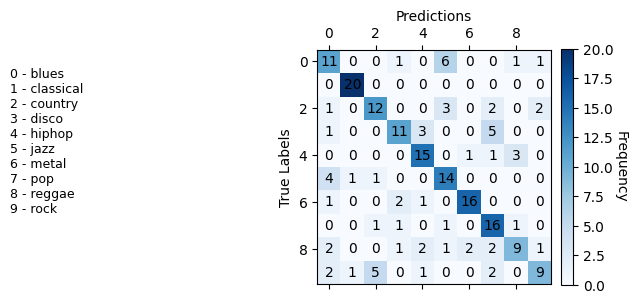

In [12]:
#Generate Confusion Matrix

model = fun.music_net()
print("Loading source...")
model, epoch, stats = fun.restore_checkpoint(model, "./checkpoints/")

sem_labels = "0 - blues\n1 - classical\n2 - country\n3 - disco\n4 - hiphop\n5 - jazz\n6 - metal\n7 - pop\n8 - reggae\n9 - rock"

# Evaluate model
fun.plot_conf(test_loader, model, sem_labels, "conf_matrix.png")